# An evaluation of NLG metrics


In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')

import os
import pandas as pd
import numpy as np
import data_utils
import matplotlib.pyplot as plt
import seaborn as sns
import metrics
import sklearn
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import scipy.stats
import xgboost
import optuna

os.environ.setdefault("TOKENIZERS_PARALLELISM", "true") # For huggingface
sns.set()


In [2]:
OUTPUT_DIR = "data/figs"
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)


def savefig(name: str, **kwargs):
    plt.savefig(
        f"{OUTPUT_DIR}/{name}.pdf", bbox_inches="tight", transparent=True, **kwargs
    )


## 1. WMT 2020 Data

In [3]:
wmt2020 = data_utils.load_data()
wmt2020.head()


,system,seg_id,source,target,mqm_avg_score,da_score,ref_A,ref_A_mqm_score,ref_B,ref_B_mqm_score,ref_P,ref_P_mqm_score
0,eTranslation.737,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.333333,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
1,Huoshan_Translate.832,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
2,Online-A.1574,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,96.333333,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
3,Online-B.1590,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333
4,OPPO.1535,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,"Um es aufs Cover zu schaffen, habe Michael Jac...",-2.333333


First, we extract the candidates and references from the data frame:

In [4]:
candidates = wmt2020.target.tolist()
references = wmt2020[["ref_A", "ref_B", "ref_P"]].to_numpy().tolist()

print("First candidate:", candidates[0], sep="\n  ")
print("Corresponding references:", *references[0], sep="\n  ")


First candidate:
  Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu bekommen, behauptet ehemaliger Bodyguard
Corresponding references:
  Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen
  Ehemaliger Bodyguard behauptet, Michael Jackson trug Pflaster auf der Nase, um in die Presse zu kommen
  Um es aufs Cover zu schaffen, habe Michael Jackson sein Riechorgan mit Klebestreifen versehen, so ein einstiger Leibwächter.


Next, we extract only the references which have a score greater than -1 (a score of -1 is equivalent to one minor error):

In [5]:
idxs_filt = []
candidates_filt = []
references_filt = []
for idx, row in wmt2020.iterrows():
    refs = []
    for human in "A", "B", "P":
        if row[f"ref_{human}_mqm_score"] > -1:
            refs.append(row[f"ref_{human}"])
    if refs:
        references_filt.append(refs)
        candidates_filt.append(row["target"])
        idxs_filt.append(idx)

data_filt = wmt2020.iloc[idxs_filt]

print("First candidate:", candidates_filt[0], sep="\n  ")
print("Corresponding references:", *references_filt[0], sep="\n  ")


First candidate:
  Michael Jackson trug Klebeband auf der Nase, um Titelseiten zu bekommen, behauptet ehemaliger Bodyguard
Corresponding references:
  Ehemaliger Bodyguard berichtet: Michael Jackson trug Klebeband auf seiner Nase, um auf die Titelseiten zu kommen
  Ehemaliger Bodyguard behauptet, Michael Jackson trug Pflaster auf der Nase, um in die Presse zu kommen


## 2. Evaluation of the dataset using automatic evaluation metrics

This evaluation is cached, and the results for the data and models we're using have been commited to git, so the following cells should run quickly.

In [6]:
m = metrics.evaluate_all(candidates, references, batch_size=1)
metrics_normal = m.columns.tolist()

m.head()


,bleu,chrf,rouge,ter,meteor,moverscore,bertscore,baryscore
0,0.452677,71.395594,0.733333,42.0,0.645236,0.689006,0.931161,0.262899
1,0.452274,62.405260,0.562500,60.0,0.535343,0.625638,0.910244,0.305000
2,0.452274,67.662048,0.645161,54.0,0.603856,0.676823,0.928487,0.221799
3,0.452274,59.576021,0.562500,60.0,0.535343,0.617522,0.909932,0.309876
4,0.452274,62.405260,0.562500,60.0,0.535343,0.625638,0.910244,0.305000


In [7]:
m_filt = metrics.evaluate_all(candidates_filt, references_filt, batch_size=1)
m_filt.set_index(np.array(idxs_filt), inplace=True)
m_filt.rename(lambda col: f"{col}_filt", axis=1, inplace=True)
metrics_filt = m_filt.columns.tolist()

m_filt.head()


,bleu_filt,chrf_filt,rouge_filt,ter_filt,meteor_filt,moverscore_filt,bertscore_filt,baryscore_filt
0,0.452677,71.395594,0.733333,43.75,0.645236,0.689015,0.931161,0.262899
1,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000
2,0.452274,67.662048,0.645161,56.25,0.603856,0.677926,0.928487,0.221799
3,0.443972,59.576021,0.562500,62.50,0.535343,0.618497,0.909932,0.309876
4,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000


In [11]:
full_data = pd.concat([wmt2020, m, m_filt], axis=1)
metrics_all = metrics_normal + metrics_filt

# We also create a version of this dataframe where all metrics
# are such that "higher is better"
full_data_sign_corrected = full_data.copy()
full_data_sign_corrected[["ter", "ter_filt", "baryscore", "baryscore_filt"]] *= -1

full_data.head(2)


,system,seg_id,source,target,mqm_avg_score,da_score,ref_A,ref_A_mqm_score,ref_B,ref_B_mqm_score,...,bertscore,baryscore,bleu_filt,chrf_filt,rouge_filt,ter_filt,meteor_filt,moverscore_filt,bertscore_filt,baryscore_filt
0,eTranslation.737,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.333333,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.931161,0.262899,0.452677,71.395594,0.733333,43.75,0.645236,0.689015,0.931161,0.262899
1,Huoshan_Translate.832,1,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",-2.666667,NaN,Ehemaliger Bodyguard berichtet: Michael Jackso...,-0.0,"Ehemaliger Bodyguard behauptet, Michael Jackso...",-0.333333,...,0.910244,0.305000,0.443972,62.405260,0.562500,62.50,0.535343,0.626687,0.910244,0.305000


## 3. Evaluation of the metrics

### 3.1 System-level correlation between the metrics

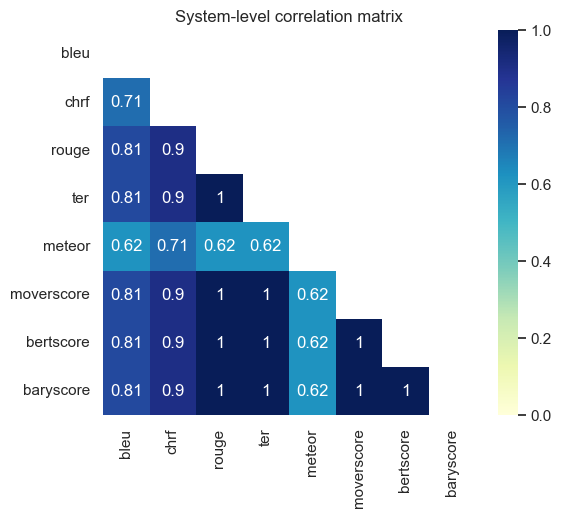

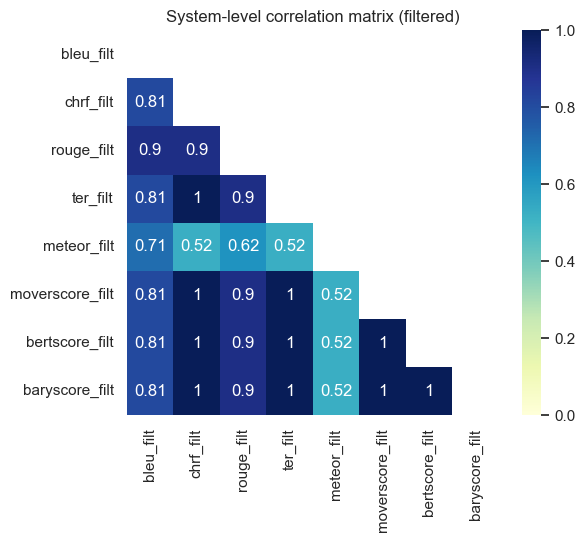

In [12]:
corr_mat = (
    full_data.groupby("system")[metrics_all + ["mqm_avg_score", "da_score"]]
    .mean()
    .corr("kendall")
    .abs()
)
mask = np.triu(np.ones_like(corr_mat.loc[metrics_normal, metrics_normal], dtype=bool))

with sns.axes_style(style="white"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat.loc[metrics_normal, metrics_normal],
        mask=mask,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        annot=True,
    )
    savefig("correlation_matrix_system_normal")
    plt.title("System-level correlation matrix")

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat.loc[metrics_filt, metrics_filt],
        mask=mask,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        annot=True,
    )
    savefig("correlation_matrix_system_filtered")
    plt.title("System-level correlation matrix (filtered)")


In [ ]:
cols = metrics_all + ["mqm_avg_score", "da_score"]
corr_mat_text = pd.DataFrame(np.nan, index=cols, columns=cols)
for i, m1 in enumerate(cols):
    corr_mat_text.loc[m1, m1] = 1
    for m2 in cols[i + 1 :]:
        r = (
            full_data.groupby("seg_id")[[m1, m2]]
            .apply(lambda group: group.corr("kendall").iloc[0, 1])
            .mean()
        )
        corr_mat_text.loc[m1, m2] = r
        corr_mat_text.loc[m2, m1] = r
corr_mat_text = corr_mat_text.abs()

with sns.axes_style(style="white"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat_text.loc[metrics_normal, metrics_normal],
        mask=mask,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        annot=True,
    )
    savefig("correlation_matrix_segment_normal")
    plt.title("Segment-level correlation matrix")

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        corr_mat_text.loc[metrics_filt, metrics_filt],
        mask=mask,
        cmap="YlGnBu",
        vmin=0,
        vmax=1,
        annot=True,
    )
    savefig("correlation_matrix_segment_filtered")
    plt.title("Segment-level correlation matrix (filtered)")


### 3.2 Correlation with human scores

In [14]:
def compute_corrs(group: pd.DataFrame, method="kendall"):
    corr = {}
    for col in ["da_score"] + metrics_all:
        if col == "mqm_avg_score":
            continue
        corr[col] = group[["mqm_avg_score", col]].corr(method).iloc[0, 1]
    return pd.Series(corr)


def compute_text_level_corrs(method="kendall"):
    return full_data.groupby("seg_id").apply(compute_corrs, method).abs()


def compute_system_level_corrs():
    cols = metrics_all + ["da_score", "mqm_avg_score"]
    corr = {}
    for method in ("pearson", "spearman", "kendall"):
        c = full_data.groupby("system")[cols].mean().corr(method)
        corr[method] = c["mqm_avg_score"].drop("mqm_avg_score")
    return pd.DataFrame(corr).abs()


text_level_corrs_pearson = compute_text_level_corrs("pearson")
text_level_corrs_spearman = compute_text_level_corrs("spearman")
text_level_corrs_kendall = compute_text_level_corrs("kendall")
text_level_corrs = pd.DataFrame(
    {
        "pearson": text_level_corrs_pearson.mean(),
        "spearman": text_level_corrs_spearman.mean(),
        "kendall": text_level_corrs_kendall.mean(),
    }
)

system_level_corrs = compute_system_level_corrs()

all_corrs = text_level_corrs.join(
    system_level_corrs, lsuffix="_text", rsuffix="_system"
)


In [15]:
system_level_corrs.loc[["da_score"] + metrics_normal]


,pearson,spearman,kendall
da_score,0.559564,0.500000,0.333333
bleu,0.847677,0.785714,0.714286
chrf,0.917628,0.892857,0.809524
rouge,0.911104,0.964286,0.904762
ter,0.854454,0.964286,0.904762
meteor,0.765526,0.607143,0.523810
moverscore,0.920849,0.964286,0.904762
bertscore,0.899390,0.964286,0.904762
baryscore,0.903519,0.964286,0.904762


In [16]:
text_level_corrs.loc[["da_score"] + metrics_normal]


,pearson,spearman,kendall
da_score,0.612632,0.598874,0.534875
bleu,0.452747,0.439424,0.363507
chrf,0.454390,0.442830,0.366136
rouge,0.443632,0.427755,0.359073
ter,0.437934,0.429094,0.367755
meteor,0.439197,0.428205,0.356125
moverscore,0.447400,0.437902,0.363658
bertscore,0.457782,0.446236,0.367981
baryscore,0.446950,0.432876,0.354571


Text(0.5, 1.0, 'Data used to compute system-level correlations')

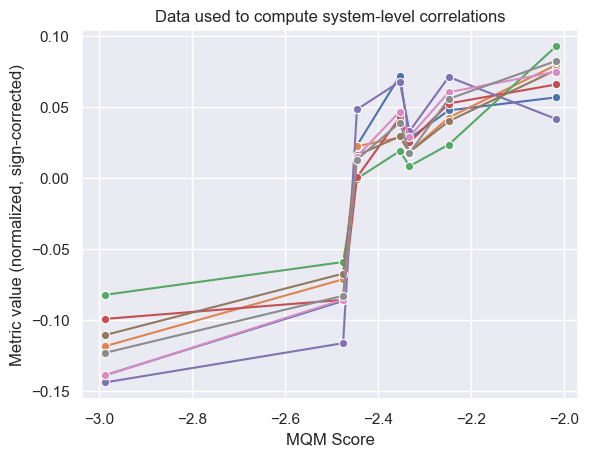

In [17]:
full_data_normalized = full_data_sign_corrected.copy()
full_data_normalized[metrics_all] -= full_data_normalized[metrics_all].mean()
full_data_normalized[metrics_all] /= full_data_normalized[metrics_all].std()

sns.lineplot(
    x="mqm_avg_score",
    y="value",
    hue="variable",
    data=full_data_normalized.groupby("system")
    .mean(numeric_only=True)
    .reset_index()
    .melt(
        id_vars=["system", "mqm_avg_score"],
        value_vars=metrics_normal,
    ),
    legend=False,
    marker="o",
)
plt.xlabel("MQM Score")
plt.ylabel("Metric value (normalized, sign-corrected)")
savefig("data_system_correlation")
plt.title("Data used to compute system-level correlations")


Text(0.5, 1.0, 'Data used to compute segment-level correlations')

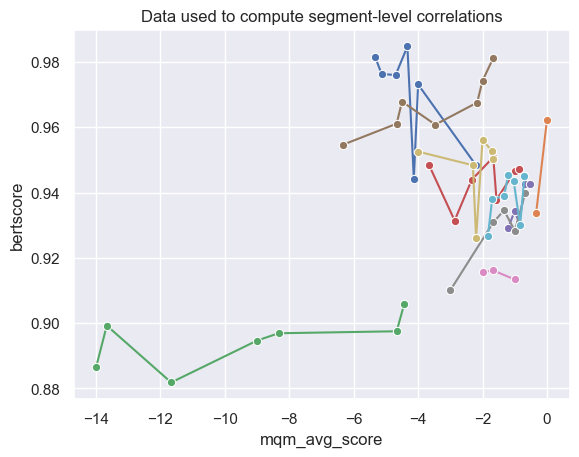

In [18]:
sample_ids = np.random.RandomState(42).choice(
    full_data["seg_id"].unique(), size=10, replace=False
)
samples = full_data[full_data["seg_id"].isin(sample_ids)]

sns.lineplot(
    x="mqm_avg_score",
    y="bertscore",
    hue=samples.seg_id.map(str),
    data=samples,
    errorbar=None,
    legend=False,
    marker="o",
)
savefig("data_segment_correlation")
plt.title("Data used to compute segment-level correlations")


Text(0.5, 1.0, 'Data used to compute system-level correlations')

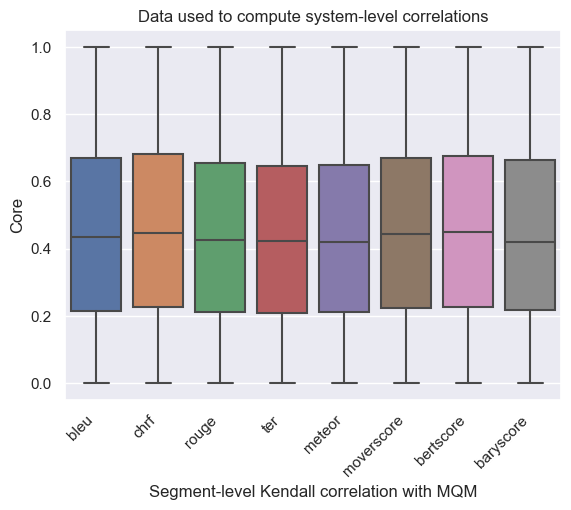

In [19]:
sns.boxplot(
    x="variable",
    y="value",
    data=text_level_corrs_pearson.melt(value_vars=metrics_normal),
)
plt.xlabel("Segment-level Kendall correlation with MQM")
plt.ylabel("Core")
plt.xticks(rotation=45, ha="right")
savefig("text_correlation_boxplot")
plt.title("Data used to compute system-level correlations")


### 3.3 Significance testing

In [45]:
def compute_significance_test_dataframe(test_fn, alpha=0.05, rows=metrics_normal, columns=metrics_normal, **kwargs):
    pval_df = corr_mat.loc[rows, columns].copy()
    pval_df[:] = np.nan
    for axis in (0, 1):
        pval_df.sort_index(
            key=lambda i: corr_mat.loc[i, "mqm_avg_score"],
            inplace=True,
            ascending=False,
            axis=axis,
        )
    for metric1 in rows:
        for metric2 in columns:
            if metric1 == metric2:
                continue
            r1 = corr_mat.loc[metric1, "mqm_avg_score"]
            r2 = corr_mat.loc[metric2, "mqm_avg_score"]
            if r1 > r2:
                pval = test_fn(metric1, metric2, **kwargs)
                if pval < alpha:
                    pval_df.loc[metric1, metric2] = pval

    return pval_df

    
# Need pearson correlation for william's test
corr_mat_pearson = (
    full_data.groupby("system")[metrics_all + ["mqm_avg_score", "da_score"]]
    .mean()
    .corr("pearson")
    .abs()
)


def williams_test_pval(metric1: str, metric2: str) -> float:
    """Performs a william test between the specified metrics and mqm_mean_score

    Returns the p-value for the following hypothesis test:
        r(metric1, mqm_mean_score) >= r(metric2, mqm_mean_score)
    where r is the pearson correlation coefficient.
    """
    # Count of systems (we have one value per system)
    n = len(full_data["system"].unique())

    r12: float = corr_mat_pearson.loc[metric1, metric2]  # type: ignore
    r13: float = corr_mat_pearson.loc[metric1, "mqm_avg_score"]  # type: ignore
    r23: float = corr_mat_pearson.loc[metric2, "mqm_avg_score"]  # type: ignore
    k = 1 - r12**2 - r13**2 - r23**2 + 2 * r12 * r13 * r23
    t_num = (r13 - r23) * np.sqrt((n - 1) * (1 + r12))
    t_denom = np.sqrt(2 * k * (n - 1) / (n - 3) + (r23 + r13) ** 2 / 4 * (1 - r12) ** 3)
    t = t_num / t_denom
    return scipy.stats.t.sf(t, df=n - 3)


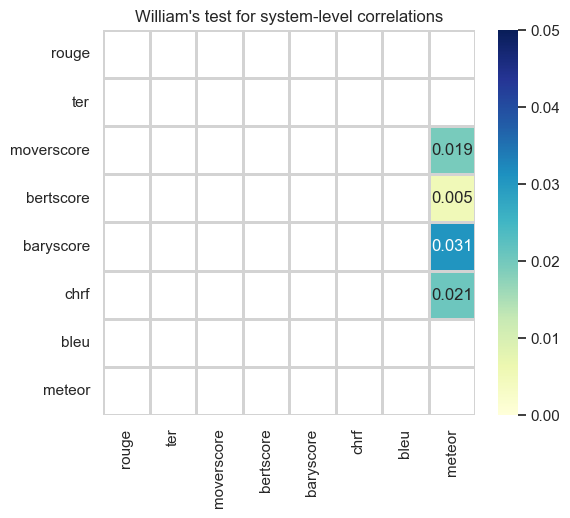

In [43]:
williams_pval = compute_significance_test_dataframe(williams_test_pval)

with sns.axes_style(style="white"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        williams_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("williams_system")
    plt.title("William's test for system-level correlations")


In [51]:
def _perm_system_corr(x: np.ndarray, y: np.ndarray, flatten=False):
    if flatten:
        x_system = x.flatten()
        y_system = y.flatten()
    else:
        x_system = np.mean(x, axis=1)
        y_system = np.mean(y, axis=1)
        
    return scipy.stats.kendalltau(x_system, y_system).correlation


def test_perm_both(metric1: str, metric2: str, k=2000, flatten=False):
    def get_mat(values: str):
        return full_data_sign_corrected.pivot(
            index="system", columns="seg_id", values=values
        ).to_numpy()

    x = get_mat(metric1)
    y = get_mat(metric2)
    z = get_mat("mqm_avg_score")

    # Standardize x and y
    x = (x - np.mean(x)) / np.std(x, ddof=1)
    y = (y - np.mean(y)) / np.std(y, ddof=1)

    c = 0
    delta = _perm_system_corr(x, z) - _perm_system_corr(y, z)
    swap_masks = np.random.choice([True, False], (k, *x.shape))
    for i in range(k):
        xs = x.copy()
        ys = y.copy()
        mask = swap_masks[i]
        xs[mask], ys[mask] = ys[mask], xs[mask]
        delta_s = _perm_system_corr(xs, z) - _perm_system_corr(ys, z)
        if delta_s > delta:
            c += 1
    return c / k


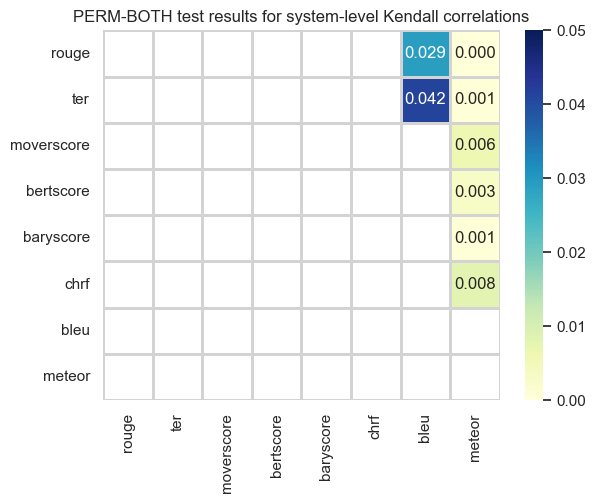

In [52]:
np.random.seed(42)
perm_both_pval = compute_significance_test_dataframe(test_perm_both)

with sns.axes_style(style="white"):
    sns.heatmap(
        perm_both_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("perm_both")
    plt.title("PERM-BOTH test results for system-level Kendall correlations")



In [ ]:
np.random.seed(42)
perm_both_pval = compute_significance_test_dataframe(test_perm_both, rows = metrics_filt, columns=metrics_filt)

with sns.axes_style(style="white"):
    sns.heatmap(
        perm_both_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("perm_both_filt")
    plt.title("PERM-BOTH test results for system-level Kendall correlations (filtered_)")


#### 3.3.2 Significance tests between filtered and non filtered metrics

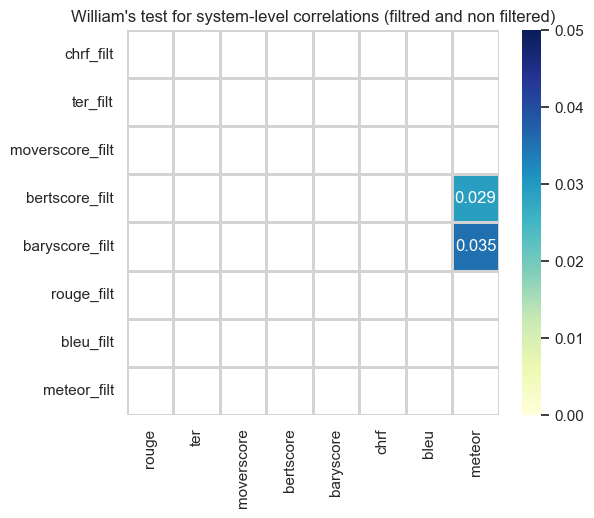

In [42]:
williams_pval = compute_significance_test_dataframe(williams_test_pval, rows=metrics_filt, columns=metrics_normal)

with sns.axes_style(style="white"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        williams_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("williams_system_normal_filt")
    plt.title("William's test for system-level correlations (filtred and non filtered)")

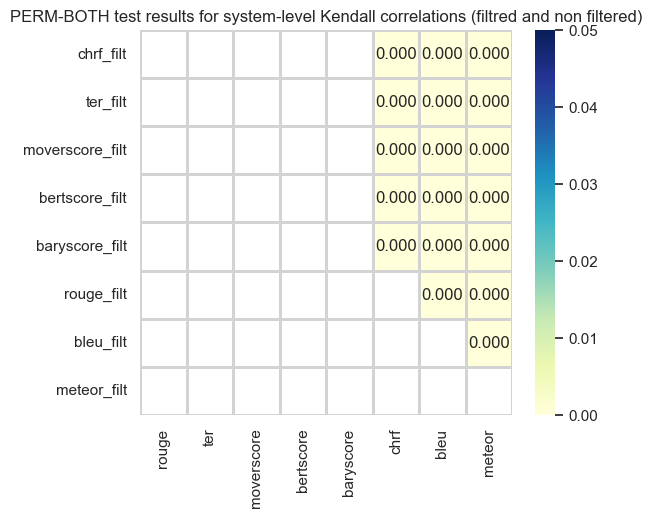

In [48]:
williams_pval = compute_significance_test_dataframe(test_perm_both, rows=metrics_filt, columns=metrics_normal)

with sns.axes_style(style="white"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        williams_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("perm_both_normal_filt")
    plt.title("PERM-BOTH test results for system-level Kendall correlations (filtred and non filtered)")

#### 3.3.4 permutation significance test with flattened array

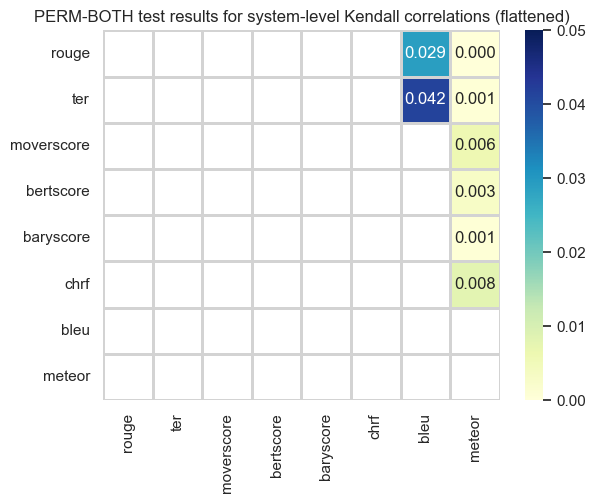

In [54]:
np.random.seed(42)
perm_both_pval = compute_significance_test_dataframe(test_perm_both, flatten=True)

with sns.axes_style(style="white"):
    sns.heatmap(
        perm_both_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("perm_both_flattened")
    plt.title("PERM-BOTH test results for system-level Kendall correlations (flattened)")

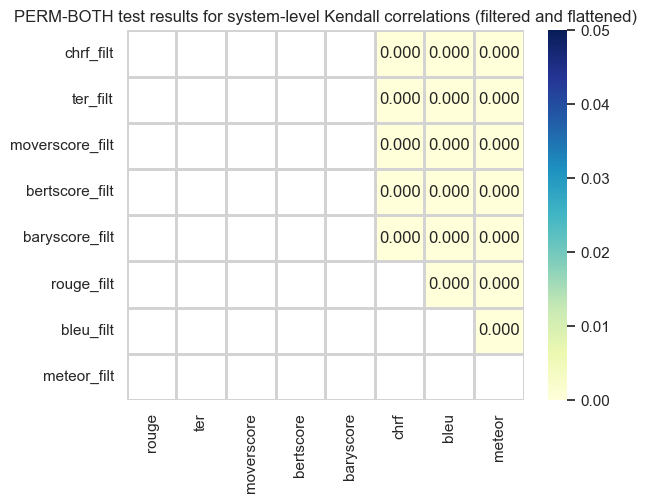

In [55]:
np.random.seed(42)
perm_both_pval = compute_significance_test_dataframe(test_perm_both, rows=metrics_filt, columns=metrics_normal, flatten=True)

with sns.axes_style(style="white"):
    sns.heatmap(
        perm_both_pval,
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=0.05,
        cmap="YlGnBu",
        lw=1,
        linecolor="lightgray",
    )
    savefig("perm_both_filt_flattened")
    plt.title("PERM-BOTH test results for system-level Kendall correlations (filtered and flattened)")

### 3.4 Correlation with error types

In [22]:
mqm = data_utils._load_mqm()
mqm.head()


,system,doc,doc_id,seg_id,rater,source,target,category,severity
0,eTranslation.737,independent.281139,1,1,rater2,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",Style/Awkward,Minor
1,eTranslation.737,independent.281139,1,1,rater4,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",Accuracy/Mistranslation,Major
2,eTranslation.737,independent.281139,1,1,rater6,Michael Jackson wore tape on his nose to get f...,"Michael Jackson trug Klebeband auf der Nase, u...",Accuracy/Mistranslation,Minor
3,Human-A.0,independent.281139,1,1,rater2,Michael Jackson wore tape on his nose to get f...,Ehemaliger Bodyguard berichtet: Michael Jackso...,No-error,no-error
4,Human-A.0,independent.281139,1,1,rater4,Michael Jackson wore tape on his nose to get f...,Ehemaliger Bodyguard berichtet: Michael Jackso...,No-error,no-error


In [23]:
# Count the average number of errors per seg_id, system and rater
error_counts = mqm.groupby(["seg_id", "system", "rater"], as_index=False)[
    ["category", "severity"]
].value_counts()
error_counts = error_counts.pivot(
    index=["seg_id", "system", "rater"],
    columns=["severity", "category"],
    values="count",
)
error_counts.sort_index(axis=1, inplace=True)
error_counts.drop(["no-error", "Neutral"], axis=1, inplace=True)
error_counts.fillna(0, inplace=True)

# For each seg_id and system, compute the average over all raters
error_counts = error_counts.groupby(level=["seg_id", "system"], axis=0).mean()
error_counts.columns = ["_".join(col) for col in error_counts.columns]

# Remove rows which contain human translations (the references)
is_human = error_counts.index.get_level_values("system").str.contains("Human-")
error_counts = error_counts[~is_human]

# Join with the metrics computed previously
score_cols = ["mqm_avg_score", "da_score"] + metrics_normal
error_cols = error_counts.columns.tolist()
error_counts = error_counts.join(
    full_data_sign_corrected.set_index(["seg_id", "system"])[score_cols]
)

# Ensure all columns go in the same direction ("lower is better")
error_counts[score_cols] *= -1


error_counts.head()


Major_Accuracy/Addition  \
seg_id system                                              
1      Huoshan_Translate.832                         0.0   
       OPPO.1535                                     0.0   
       Online-A.1574                                 0.0   
       Online-B.1590                                 0.0   
       Tencent_Translation.1520                      0.0   

                                 Major_Accuracy/Mistranslation  \
seg_id system                                                    
1      Huoshan_Translate.832                          0.333333   
       OPPO.1535                                      0.333333   
       Online-A.1574                                  0.333333   
       Online-B.1590                                  0.333333   
       Tencent_Translation.1520                       0.333333   

                                 Major_Accuracy/Omission  \
seg_id system                                              
1      Huoshan_Translate.832                         0.0   
       OPPO.1535                                     0.0   
       Online-A.1574                                 0.0   
       Online-B.1590                                 0.0   
       Tencent_Translation.1520                      0.0   

                                 Major_Accuracy/Untranslated text  \
seg_id system                                                       
1      Huoshan_Translate.832                                  0.0   
       OPPO.1535                                              0.0   
       Online-A.1574                                          0.0   
       Online-B.1590                                          0.0   
       Tencent_Translation.1520                               0.0   

                                 Major_Fluency/Character encoding  \
seg_id system                                                       
1      Huoshan_Translate.832                                  0.0   
       OPPO.1535                                              0.0   
       Online-A.1574                                          0.0   
       Online-B.1590                                          0.0   
       Tencent_Translation.1520                               0.0   

                                 Major_Fluency/Grammar  \
seg_id system                                            
1      Huoshan_Translate.832                       0.0   
       OPPO.1535                                   0.0   
       Online-A.1574                               0.0   
       Online-B.1590                               0.0   
       Tencent_Translation.1520                    0.0   

                                 Major_Fluency/Inconsistency  \
seg_id system                                                  
1      Huoshan_Translate.832                             0.0   
       OPPO.1535                                         0.0   
       Online-A.1574                                     0.0   
       Online-B.1590                                     0.0   
       Tencent_Translation.1520                          0.0   

                                 Major_Fluency/Punctuation  \
seg_id system                                                
1      Huoshan_Translate.832                           0.0   
       OPPO.1535                                       0.0   
       Online-A.1574                                   0.0   
       Online-B.1590                                   0.0   
       Tencent_Translation.1520                        0.0   

                                 Major_Fluency/Register  \
seg_id system                                             
1      Huoshan_Translate.832                        0.0   
       OPPO.1535                                    0.0   
       Online-A.1574                                0.0   
       Online-B.1590                                0.0   
       Tencent_Translation.1520                     0.0   

                                 Major_Fluency/Spelling

Text(0.5, 1.0, 'Kendall correlations between metrics and error counts')

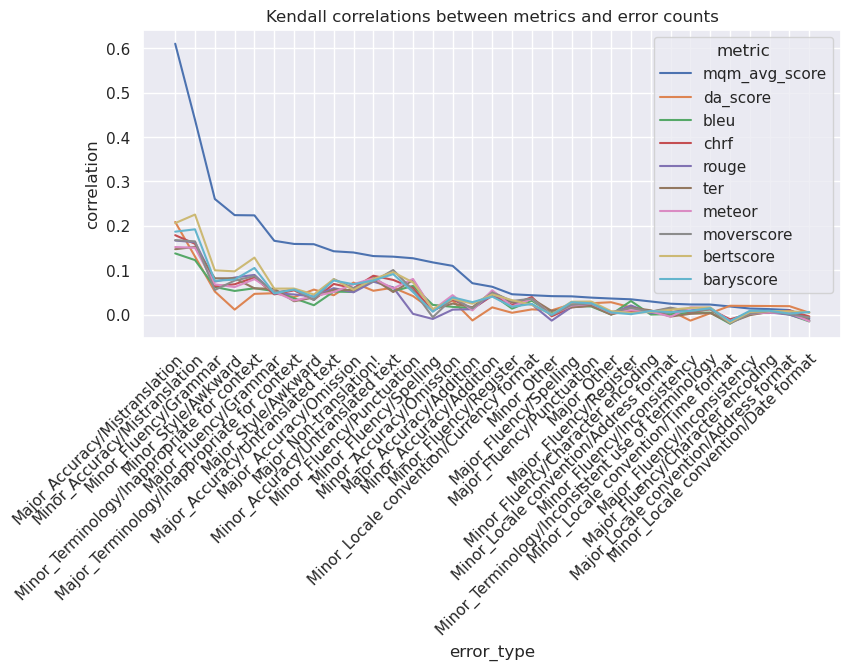

In [24]:
corr = (
    error_counts.corr("kendall")
    .loc[error_cols, score_cols]
    .sort_values("mqm_avg_score", ascending=False)
)

corr_melt = corr.reset_index(drop=False, names="error_type").melt(
    id_vars="error_type",
    value_vars=corr.columns,
    var_name="metric",
    value_name="correlation",
)
plt.figure(figsize=(9, 4))
sns.lineplot(x="error_type", y="correlation", hue="metric", data=corr_melt)
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
savefig("correlation_errors_detailed")
plt.title("Kendall correlations between metrics and error counts")


In [25]:
# Group errors by their main category
error_counts_simple = error_counts.copy()
error_counts_simple.columns = pd.MultiIndex.from_tuples([col.split("/") for col in error_counts.columns])
error_counts_simple = error_counts_simple.groupby(level=0, axis=1).sum()
error_cols_simple = list(set(error_counts_simple.columns) - set(score_cols))

error_counts_simple.head()

Major_Accuracy  Major_Fluency  \
seg_id system                                                    
1      Huoshan_Translate.832           0.333333            0.0   
       OPPO.1535                       0.333333            0.0   
       Online-A.1574                   0.333333            0.0   
       Online-B.1590                   0.333333            0.0   
       Tencent_Translation.1520        0.333333            0.0   

                                 Major_Locale convention  \
seg_id system                                              
1      Huoshan_Translate.832                         0.0   
       OPPO.1535                                     0.0   
       Online-A.1574                                 0.0   
       Online-B.1590                                 0.0   
       Tencent_Translation.1520                      0.0   

                                 Major_Non-translation!  Major_Other  \
seg_id system                                                          
1      Huoshan_Translate.832                        0.0          0.0   
       OPPO.1535                                    0.0          0.0   
       Online-A.1574                                0.0          0.0   
       Online-B.1590                                0.0          0.0   
       Tencent_Translation.1520                     0.0          0.0   

                                 Major_Style  Major_Terminology  \
seg_id system                                                     
1      Huoshan_Translate.832             0.0                0.0   
       OPPO.1535                         0.0                0.0   
       Online-A.1574                     0.0                0.0   
       Online-B.1590                     0.0                0.0   
       Tencent_Translation.1520          0.0                0.0   

                                 Minor_Accuracy  Minor_Fluency  \
seg_id system                                                    
1      Huoshan_Translate.832           0.333333            0.0   
       OPPO.1535                       0.333333            0.0   
       Online-A.1574                   0.333333            0.0   
       Online-B.1590                   0.333333            0.0   
       Tencent_Translation.1520        0.333333            0.0   

                                 Minor_Locale convention  ...  baryscore  \
seg_id system                                             ...              
1      Huoshan_Translate.832                         0.0  ...   0.305000   
       OPPO.1535                                     0.0  ...   0.305000   
       Online-A.1574                                 0.0  ...   0.221799   
       Online-B.1590                                 0.0  ...   0.309876   
       Tencent_Translation.1520                      0.0  ...   0.221799   

                                 bertscore      bleu       chrf   da_score  \
seg_id system                                                                
1      Huoshan_Translate.832     -0.910244 -0.452274 -62.405260   0.000000   
       OPPO.1535                 -0.910244 -0.452274 -62.405260   0.000000   
       Online-A.1574             -0.928487 -0.452274 -67.662048 -96.333333   
       Online-B.1590             -0.909932 -0.452274 -59.576021   0.000000   
       Tencent_Translation.1520  -0.928487 -0.452274 -67.662048 -96.333333   

                                   meteor  moverscore  mqm_avg_score  \
seg_id system                                                          
1      Huoshan_Translate.832    -0.535343   -0.625638       2.666667   
       OPPO.1535                -0.535343   -0.625638       2.666667   
       Online-A.1574            -0.603856   -0.676823       2.666667   
       Online-B.1590            -0.535343   -0.617522       2.666667   
       Tencent_Translation.1520 -0.603856   -0.676823       2.666667   

                                    rouge   ter  
seg_id system                                    
1      Huoshan_Translate.8

Text(0.5, 1.0, 'Kendall correlations between metrics and error counts')

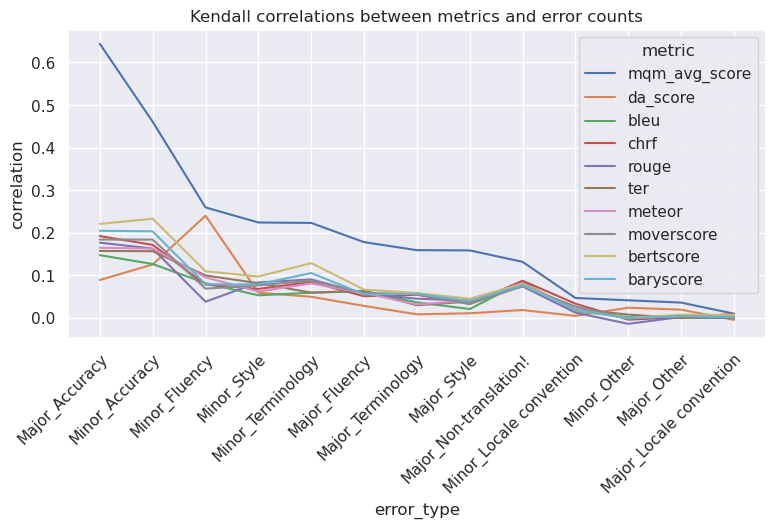

In [26]:
corr = (
    error_counts_simple.corr("kendall")
    .loc[error_cols_simple, score_cols]
    .sort_values("mqm_avg_score", ascending=False)
)

corr_melt = corr.reset_index(drop=False, names="error_type").melt(
    id_vars="error_type",
    value_vars=corr.columns,
    var_name="metric",
    value_name="correlation",
)
plt.figure(figsize=(9, 4))
sns.lineplot(x="error_type", y="correlation", hue="metric", data=corr_melt)
plt.xticks(rotation=45, rotation_mode="anchor", ha="right")
savefig("correlation_errors")
plt.title("Kendall correlations between metrics and error counts")


### 3.5 Predicting MQM with automatic metrics

In [27]:
X = full_data.loc[:, metrics_normal]
y = full_data.loc[:, "mqm_avg_score"]

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2, random_state=42
)


tau score: 0.34678153273466544


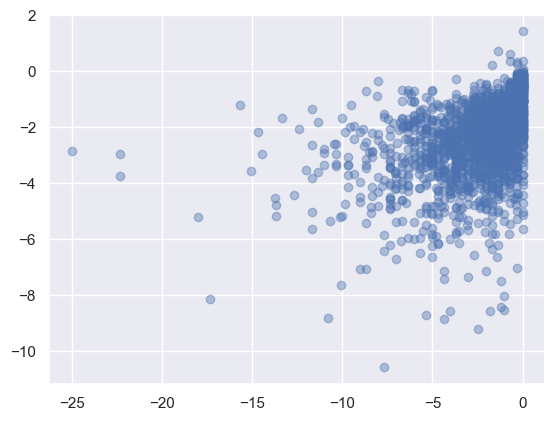

In [28]:
xgb_regressor = xgboost.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

print(f"tau score: {scipy.stats.kendalltau(y_test, y_pred)[0]}")

plt.scatter(y_test, y_pred, alpha=0.4)


#### Optimize model hyperparameters

In [29]:
def optimize(trials: optuna.Trial):
    params = {
        "n_estimators": trials.suggest_int("n_estimators", 1, 500),
        "learning_rate": trials.suggest_float("learning_rate", 0, 1),
        "min_split_loss": trials.suggest_float("min_split_loss", 0, 10),
        "max_depth": trials.suggest_int("max_depth", 1, 30),
        "subsample": trials.suggest_float("subsample", 0, 1),
        "reg_lambda": trials.suggest_float("reg_lambda", 0, 5),
        "reg_alpha": trials.suggest_float("reg_alpha", 0, 5),
        "grow_policy": trials.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "verbosity": 0,
        "nthread": 8,
    }

    def kendall_score(y_true, y_pred):
        return scipy.stats.kendalltau(y_true, y_pred)[0]

    kf = sklearn.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    reg_xgboost = xgboost.XGBRegressor(**params)
    scores = sklearn.model_selection.cross_val_score(
        reg_xgboost,
        X_train,
        y_train,
        cv=kf,
        scoring=sklearn.metrics.make_scorer(kendall_score),
    )
    return np.mean(scores)


In [ ]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(multivariate=True), direction="maximize"
)
study.optimize(optimize, n_trials=100)
print(study.best_params, study.best_value)


#### compare model

In [14]:
xgboost_params = {
    'n_estimators': 364, 
    'learning_rate': 0.036631422567591006,
    'min_split_loss': 0.1527162494419042,
    'max_depth': 24,
    'subsample': 0.568555379762411,
    'reg_lambda': 3.9318045624725553,
    'reg_alpha': 1.0475319844544235,
    'grow_policy': 'lossguide'
}

In [17]:
reg_xgboost = xgboost.XGBRegressor(**xgboost_params)
reg_xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.036631422567591006, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=24, max_leaves=None,
             min_child_weight=None, min_split_loss=0.1527162494419042,
             missing=nan, monotone_constraints=None, n_estimators=364,
             n_jobs=None, num_parallel_tree=None, predictor=None, ...)

In [16]:
y_pred = reg_xgboost.predict(X_test)

print(scipy.stats.kendalltau(y_test, y_pred)[0])


plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([-25,0], [-25,0], color='red', zorder=0)

NotFittedError: need to call fit or load_model beforehand

In [1]:
print(f'pearson : {scipy.stats.pearsonr(y_test, y_pred)[0]}')
print(f'spearman : {scipy.stats.spearmanr(y_test, y_pred)[0]}')
print(f'kendalltau : {scipy.stats.kendalltau(y_test, y_pred)[0]}')

NameError: name 'scipy' is not defined